 # Load the relevant packages

In [8]:
library("BPSC")
library("SingleCellExperiment")
library("scater")
library("biomaRt")
library("Matrix")
library('scuttle')
library("pheatmap")
library("MAST")
library("iDEA")
library("ggrepel")

# Load workspace, so that all relevant info is loaded at once

In [2]:
load("workspace_bin330.RData")

Has the following data:
- loaded the data
- cleaning and quality control
- normalization
- cell type info
- biomRt
- Generalization: combinations, annotation as df, genes of interest
- result of iDEA for-loop run on 90 comparisons. 

So, from here you can jump to visualization

# Load the data: start with count matrix, then gene and cell annotation data.

In [3]:
gene_by_cell_count_matrix <- read.csv("GSE126954_gene_by_cell_count_matrix.txt", sep = "")[,1:3]

In [4]:
gene_annotation <- read.csv("GSE126954_gene_annotation.csv")[,2:3]
cell_annotation <- read.csv("GSE126954_cell_annotation.csv")[,-1]

Generate a sparse matrix from the counts matrix. Rows represent a gene, columns represent a cell.

In [5]:
data_matrix = sparseMatrix(i=gene_by_cell_count_matrix$X..MatrixMarket,
                          j=gene_by_cell_count_matrix$matrix,
                          x=gene_by_cell_count_matrix$coordinate
                           )
rownames(data_matrix)=gene_annotation[,1]
colnames(data_matrix)=cell_annotation[,1]

In [6]:
head(data_matrix)
dim(data_matrix)

   [[ suppressing 34 column names ‘AAACCTGAGACAATAC-300.1.1’, ‘AAACCTGAGGGCTCTC-300.1.1’, ‘AAACCTGAGTGCGTGA-300.1.1’ ... ]]



6 x 89701 sparse Matrix of class "dgCMatrix"
                                                                               
WBGene00010957 5 20 37 26 4 1 73 7 17 12 10 11 2 4  7 10 0 21 26 11 29 1 39 5 6
WBGene00010958 .  .  .  1 . .  . .  .  .  .  . . .  .  . .  3  1  .  1 .  2 . .
WBGene00010959 0  7 16 14 2 . 38 2 10  5  4  9 2 6  4  0 . 14  7  5  8 1 25 3 1
WBGene00010960 7 17 28 52 7 . 76 0 16  8  9  5 6 5 12  0 1 38 19  5 21 1 95 6 6
WBGene00010961 3  .  0  5 . 2  9 1  2  2  2  . . 2  0  . 1  3  2  2  4 .  5 1 .
WBGene00000829 5  5 13 17 . 0 17 0 11  1  5  3 5 3  4  1 1 13  4  1 11 2 14 4 1
                                             
WBGene00010957  5 3 70 10 11 4 16 3 28 ......
WBGene00010958  1 .  2  .  . .  . 1  2 ......
WBGene00010959  1 1 48  6  4 2 17 3 26 ......
WBGene00010960 10 3 91  9 16 2 23 2 76 ......
WBGene00010961  . .  5  .  . 1  3 3  5 ......
WBGene00000829  5 2 25  1  4 0  6 6  9 ......

 .....suppressing 89667 columns in show(); maybe adjust 'options(max.pri

[1] 20222 89701

Select one time bin.

In [7]:
cells_bin = cell_annotation[cell_annotation$raw.embryo.time.bin=="330-390",]
data_matrix = data_matrix[,as.numeric(unlist(rownames(cells_bin)))]

Create SingleCellExperiment objects

In [8]:
sce <- SingleCellExperiment(
  assays = list(counts = data_matrix),
  rowData = data.frame(gene_names = rownames(data_matrix)),
  colData = data.frame(cell_names = colnames(data_matrix))
)

# Cleaning & QC

Use this object to clean the dataset by removing genes that are not expressed in any cell

In [9]:
## Remove genes that are not expressed in any cell
keep_feature <- rowSums(counts(sce) > 0) > 0
sce_filtered <- SingleCellExperiment(
  assays = list(counts = counts(sce)[keep_feature, ]),
  rowData = data.frame(gene_names = rowData(sce)[keep_feature,]),
  colData = data.frame(cell_names = colData(sce))
)

Do some quality control

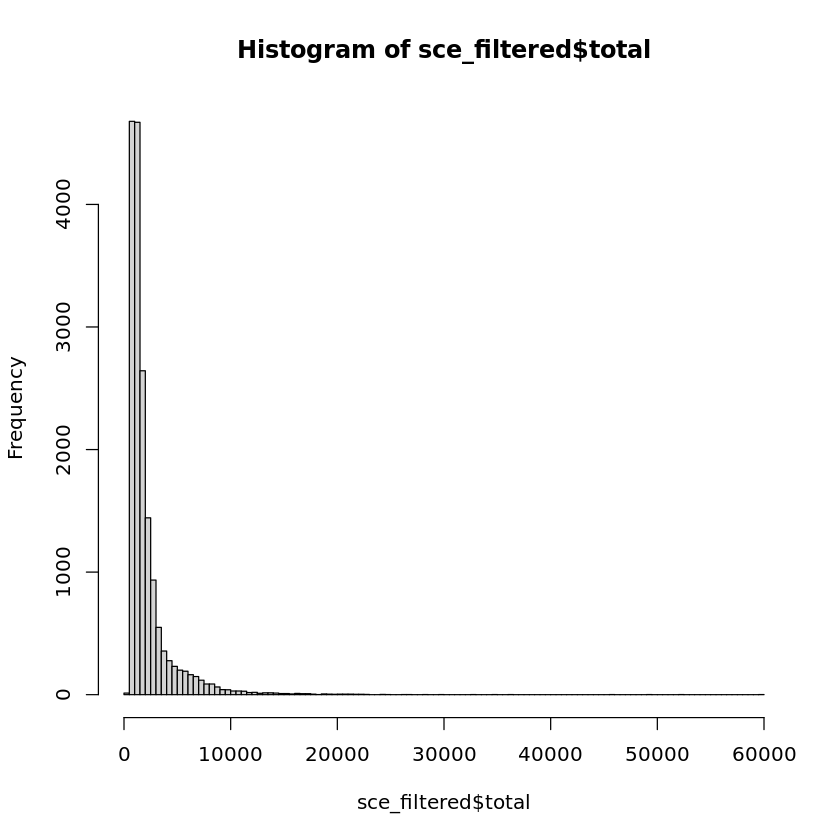

In [10]:
sce_filtered <- addPerCellQC(sce_filtered)
sce_filtered <- addPerFeatureQC(sce_filtered)
hist(sce_filtered$total, breaks = 100) #hist of counts per cell

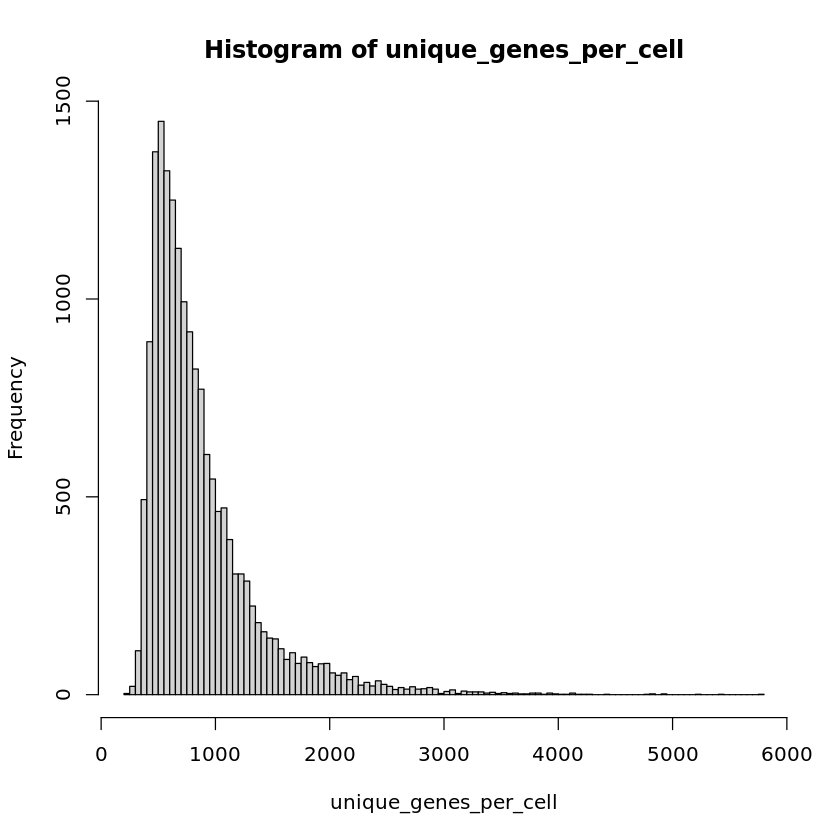

In [11]:
unique_genes_per_cell <- colSums(counts(sce)>0)
hist(unique_genes_per_cell,breaks=100) #hist of unique genes per cell

If needed, these histograms can be used to determine thresholds for further filtering. 

# Normalize the counts using CPM

In [12]:
cpm(sce_filtered) <- calculateCPM(sce_filtered) # using scater package
sce_filtered <- logNormCounts(sce_filtered,transform="log") 
# this logNormCounts function comes from scuttle package. Do not change sce_filtered into logcounts(sce_filtered) although that seems more logical.
# The CPM and log counts are now stored in this sce_filtered SCE object
# str(sce_filtered) shows the hierarchical structure of this SCE object

In [13]:
# Sparse matrices for further analysis
sce_cpm <- cpm(sce_filtered) # CPM for BPSC input
sce_log <- sce_filtered@assays@data@listData$logcounts # log transformed counts for heatmap input

# Cell Type Info

Generate the column indices of the gene expression matrix corresponding to each cell type.
First, generate the cell types included in the matrix being analyzed and make them correspond to the cell names (column names of the matrix)cell_annotation[,6] contains the cell types we need. We use them to split the data into groups containing gene expression of different cell types. dimnames(sce_cpm)[[2]] contains the column names of the sparse matrix.

In [14]:
cell_type <- cell_annotation[cell_annotation$cell %in% dimnames(sce_cpm)[[2]],6] 

Unique values in the vector cell_type that is not NA. We do not want to take the type-unidentified (na) cells into the differential expression analysis.

In [15]:
unique_cell_types <- unique(cell_type)[!is.na(unique(cell_type))]
unique_cell_types
length(unique_cell_types)

[1] "Body_wall_muscle"              "Ciliated_amphid_neuron"       
 [3] "Hypodermis"                    "Ciliated_non_amphid_neuron"   
 [5] "Seam_cell"                     "Intestine"                    
 [7] "GLR"                           "Z1_Z4"                        
 [9] "Pharyngeal_muscle"             "Pharyngeal_marginal_cell"     
[11] "Pharyngeal_gland"              "Intestinal_and_rectal_muscle" 
[13] "G2_and_W_blasts"               "Glia"                         
[15] "hmc_and_homolog"               "Parent_of_exc_gland_AVK"      
[17] "Pharyngeal_intestinal_valve"   "Coelomocyte"                  
[19] "hmc_homolog"                   "Excretory_cell"               
[21] "Pharyngeal_neuron"             "hyp1V_and_ant_arc_V"          
[23] "M_cell"                        "Rectal_cell"                  
[25] "ABarpaaa_lineage"              "hmc"                          
[27] "Rectal_gland"                  "Excretory_duct_and_pore"      
[29] "Excretory_gland"               "Parent_of_hyp1V_and_ant_arc_V"
[31] "Arcade_cell"                   "XXX"                          
[33] "Germline"                      "T"

[1] 34

Create a list for cell indices

In [16]:
cell_indices <- list()
# Extract the cell indices according to each of the cell type and put them in the list
for (i in 1:length(unique_cell_types)){
  cell_indices[[unique_cell_types[i]]] <- dimnames(sce_filtered[,which(cell_type==unique_cell_types[i])])[[2]]
}

We can retrieve the cell indices of a cell type  by either the index of the list, or the cell type such as 'Body_wall_muscle'

In [17]:
cell_indices[[1]][1:5]
cell_indices[['Body_wall_muscle']][1:5]

[1] "AAACCTGAGACAATAC-300.1.1" "AAACCTGGTTATGCGT-300.1.1"
[3] "AAAGCAACATCTATGG-300.1.1" "AACCGCGCACATGACT-300.1.1"
[5] "AACTCCCAGGGTTTCT-300.1.1"

[1] "AAACCTGAGACAATAC-300.1.1" "AAACCTGGTTATGCGT-300.1.1"
[3] "AAAGCAACATCTATGG-300.1.1" "AACCGCGCACATGACT-300.1.1"
[5] "AACTCCCAGGGTTTCT-300.1.1"

# BiomRT

In [18]:
# Use biomRT package to get access to WormBase ParaSite BioMart
# Establish a connection to the WormBase ParaSite BioMart
mart <- useMart("parasite_mart", dataset = "wbps_gene", host = "https://parasite.wormbase.org", port = 443)

In [19]:
# Retrieve the GO terms
gene_info <- getBM(filters="wbps_gene_id", 
  attributes=c("wbps_gene_id", "go_accession","go_name_1006", "go_namespace_1003"), 
  values=row.names(data_matrix), 
  mart=mart,
  uniqueRows=FALSE)

In [20]:
dim(gene_info) 

[1] 207455      4

In [21]:
head(gene_info)

,wbps_gene_id,go_accession,go_name_1006,go_namespace_1003
,<chr>,<chr>,<chr>,<chr>
1,WBGene00000002,GO:0016021,integral component of membrane,cellular_component
2,WBGene00000002,GO:0016020,membrane,cellular_component
3,WBGene00000002,GO:0022857,transmembrane transporter activity,molecular_function
4,WBGene00000002,GO:0055085,transmembrane transport,biological_process
5,WBGene00000002,GO:0005886,plasma membrane,cellular_component
6,WBGene00000002,GO:0015807,L-amino acid transport,biological_process


# Construction of Annotation Matrix

Construct an annotation matrix, where rows represent genes, columns go-names and the values are 1 when a go-term of that column is related to the gene of that row. This is needed for the iDEA analysis.

In [22]:
# go_names for which there is still a related gene in the filtered data set
rel_gene_info = gene_info[which(gene_info$wbps_gene_id %in% rownames(sce_cpm)),]

In [23]:
# make an empty sparse matrix for which each row represents a gene, and each column represents a go_name
# The nb of columns thus corresponds to the number of unique go_names that are connected to the genes after filtering.
annotation = sparseMatrix(i=nrow(sce_cpm),
                          j=length(unique(rel_gene_info$go_name_1006)),
                          x=0
                           )
rownames(annotation)<-rownames(sce_cpm) # rows in annotation represent genes
colnames(annotation)<-unique(rel_gene_info$go_name_1006) # columns in annotation represent go-terms

In [24]:
startTime = Sys.time()
for (i in 1:nrow(rel_gene_info)){ # for each gene 
    # get the row in the annotation matrix that corresponds to that gene
    gene_index = which(rownames(annotation) == rel_gene_info$wbps_gene_id[i]) 
    # get the column in the annotation matrix that corresponds to the go-name
    go_name_index = which(colnames(annotation) == rel_gene_info$go_name_1006[i])
    # set the relevant element in the annotation to 1
    annotation[gene_index,go_name_index] = 1
}
endTime = Sys.time()
print(endTime - startTime)

Time difference of 3.483985 mins


```
summary(rowSums(annotation)==0)
summary(colSums(annotation)==0)

   Mode   FALSE    TRUE 
logical   16957      83 
   Mode   FALSE 
logical    6896 
```

In [25]:
annotation_matrix = as.matrix(annotation)
annotation_df = as.data.frame(annotation_matrix)
annotation = annotation_df

# Pair-wise comparison of groups of cell types, for all expressed genes

We merge the cell types we're interested in to 4 major categories: muscle cells, neurons, glands, and hypodermis.

In [3]:
cbind(1:length(unique_cell_types), as.data.frame(unique_cell_types))

1:length(unique_cell_types),unique_cell_types
<int>,<chr>
1,Body_wall_muscle
2,Ciliated_amphid_neuron
3,Hypodermis
4,Ciliated_non_amphid_neuron
5,Seam_cell
6,Intestine
7,GLR
8,Z1_Z4
9,Pharyngeal_muscle


In [4]:
#select the cell types of interest
muscle_cell_types = unique_cell_types[c(1,9,12)]
neuron_cell_types = unique_cell_types[c(2,4,21)]
gland_cell_types = unique_cell_types[c(11,16,27,29)]
hyp_cell_types = unique_cell_types[c(3)]

#make vector of group names: useful for later for-loops
cell_groups_of_interest = c("muscle_cells", "neuron_cells", "gland_cells", "hyp_cells")
#make list with each element the cell types belonging to a respective group
grouped_cell_types = list(muscle_cell_types, neuron_cell_types, gland_cell_types, hyp_cell_types)

#create empty list, of which the elements will eventually hold all cell identifiers belonging to a by us defined group
# (those groups have group names as in cell_groups_of_interest). This list can be used to retrieve all cells 
# belonging to a group
cell_indices4groups = list(NULL, NULL, NULL, NULL)
names(cell_indices4groups) = cell_groups_of_interest

#for-loop to give cell identifiers belonging to a by us defined group. 
for (j in 1:length(cell_groups_of_interest)){
    for (i in 1:length(grouped_cell_types[[j]])){
        cell_indices4groups[[j]] = append(cell_indices4groups[[j]], cell_indices[[grouped_cell_types[[j]][i]]])
    }
}

Now, we do the analysis for all genes and these groups of cells.

In [5]:
# define a dataframe holding all combinations of 1:4. Will be used to compare corresponding groups of cell types
combinations4groups = data.frame()
for (i in 1:(length(cell_indices4groups)-1)){
    for (j in (i+1):length(cell_indices4groups)){
        row = c(i,j)
        combinations4groups = rbind(combinations4groups, row)
    }
}

In [ ]:
# Create a list for log fold change + p-value from BPSC results and for iDEA results
results4groups <- list()
list_of_idea4groups = list()

options(mc.cores = 1) # to fix an error. Has to do with, problems in parallelization in idea

for (i in 2:4){
    print(i)
    startTime = Sys.time()
    #Define the two groups to be compared (Remember of remove 1:20 when we run it for the whole data containing all the cells in a time bin!!!)
    control.mat=sce_cpm[,cell_indices4groups[[combinations4groups[i,1]]]]
    treated.mat=sce_cpm[,cell_indices4groups[[combinations4groups[i,2]]]]
    #Create a data set by merging the control group and the treated group
    bp.mat=cbind(control.mat,treated.mat)
    rownames(bp.mat)=c(1:nrow(bp.mat))
    colnames(bp.mat)=c(1:ncol(bp.mat))
    group=c(rep(1,ncol(control.mat)),rep(2,ncol(treated.mat)))

    #Run BPglm for differential expression analysis
    res=BPglm(data=bp.mat, controlIds=which(lapply(group, as.numeric)==1), design=model.matrix(~group), coef=2, estIntPar=FALSE, useParallel=FALSE)
    
    # Use MAST to compute logFC based on the raw counts
    control.countData=sce_filtered[,cell_indices4groups[[combinations4groups[i,1]]]]
    treated.countData=sce_filtered[,cell_indices4groups[[combinations4groups[i,2]]]]
    countData <- cbind(control.countData,treated.countData)
    cellType <- as.data.frame(rep(c(1,2), c(ncol(control.countData),ncol(treated.countData))))
    colnames(cellType) <- "CellType"
    colData(countData) <- cbind(colData(countData),cellType)
    colData(countData)$CellType<-factor(colData(countData)$CellType)
    countData<-SceToSingleCellAssay(countData, class = "SingleCellAssay",check_sanity = FALSE)
    zlmCond <- zlm(~CellType, countData)
    logFC<-getLogFC(zlmCond)[,c(1,3)]

    # Log fold change + p-value from BPSC
    PVAL<-as.data.frame(res$PVAL)
    result <- cbind(logFC,res$PVAL)
    colnames(result) <- c('gene','logFC','P-value')
    results4groups[[paste(cell_groups_of_interest[combinations4groups[i,1]],
                        cell_groups_of_interest[combinations4groups[i,2]], sep=" vs. ")]] = result

    #calculate variance
    #Here the first results(only two cell types) is used!!
    pvalue <- result$`P-value` #### the pvalue column
    zscore <- qnorm(pvalue/2.0, lower.tail=FALSE) #### convert the pvalue to z-score
    fc <- result$logFC ## the fold change column
    se_beta <- abs(fc/zscore) ## to approximate the standard error of beta
    var = se_beta^2  ### square 
    summary = data.frame(fc = fc,variance = var,row.names = result$gene)# Summary is a matrix of fold change and variance of each gene

    #create idea object
    idea<-CreateiDEAObject(summary,annotation[,])
    #Fit the model
    idea <- iDEA.fit(idea)
    #correct p-values
    idea <- iDEA.louis(idea)
    #without pre-selected genes
    idea <- iDEA.BMA(idea)

    #Save idea to list, so we can do analysis later
    list_of_idea4groups <- cbind(list_of_idea4groups,idea)

    save(idea, file=paste0("bin330_idea_groups_comp",i,".RData"))
    save(result, file=paste0("bin330_result_groups_comp",i,".RData"))
    
    stopTime = Sys.time()
    print(stopTime-startTime)
} 

[1] 2


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.


Done!



## ===== iDEA INPUT SUMMARY ==== ##
## number of annotations:  372 
## number of genes:  9370 
## number of cores:  10 
## fitting the model with gene sets information... 
Time difference of 3.315943 hours
[1] 3


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.


Done!



## ===== iDEA INPUT SUMMARY ==== ##
## number of annotations:  336 
## number of genes:  12190 
## number of cores:  10 
## fitting the model with gene sets information... 
Time difference of 3.877662 hours
[1] 4


`fData` has no primerid.  I'll make something up.

`cData` has no wellKey.  I'll make something up.


Done!



# Visualization
## Bubble Plots

The following function can be used to make bubble plots for iDEA objects.

In [6]:
# This function makes a bubble plot with info in an iDEA-object.
CreateBubblePlot = function(idea_obj){
    # calculate the number of genes that are associated with the go-terms found in the gsea
    df_colSums = as.data.frame(colSums(annotation[,colnames(annotation) %in% idea_obj@gsea[,1]]))
    # also save their p-value
    df_pval = as.data.frame(-log(idea_obj@gsea$pvalue, base = 10))
    # give rows the name of the corresponding go-term
    rownames(df_pval) = idea_obj@gsea$annot_id
    # make a preliminary dataframe with the go-terms, the nb of genes associated, and the p-values
    data = cbind(rownames(df_pval), df_colSums)
    data = cbind(data, df_pval)

    # determine the domain of the go terms
    ## Initiation of for loop: create empty dataframe that will hold all the go-domains
    df_domains = data.frame()
    ## loop over each row in data
    for (i in 1:nrow(data)){
        ## determine the go-term of that row
        go_term = rownames(data[i,])
        ## determine the go-domain of that go-term
        go_domain = unique(gene_info$go_namespace_1003[gene_info$go_name_1006==go_term])
        ## some go-terms don't belong to a domain. To prevent they are skipped, assign "other" to the domain
        if (length(go_domain) == 0) go_domain = "other"
        ## add a row with the domain to the domain dataframe
        df_domains = rbind(df_domains,go_domain)
    }

    # add the domain dataframe as a new column to the data
    data = cbind(data,df_domains)
    # assign colnames to the data
    colnames(data) = c("go_term", "genes_in_go", "log_p", "go_domain")
    
    categoryLevels = c("biological_process", "cellular_component", "molecular_function")
    data = data[order(match(data$go_domain, categoryLevels)), ]
    data = cbind(data, order(match(data$go_domain, categoryLevels)))
    colnames(data) = c("go_term", "genes_in_go", "log_p", "go_domain", "order")
    
    plot = ggplot(data, aes(x=order, y=log_p, size = genes_in_go, color = go_domain)) +
            geom_point(alpha=0.7) +
            geom_hline(yintercept = -log(0.05, base=10)) + 
            scale_x_continuous(name = "", breaks = c()) + 
            labs(title=paste(paste("bin330: ", cell_groups_of_interest[combinations4groups[i,1]]), 
                             paste(" vs ", cell_groups_of_interest[combinations4groups[i,2]]))) +
            geom_text_repel(aes(label=ifelse(log_p>15 & log_p<100,go_term,'')),size = 12/.pt,force=5)
    
    return (plot)
}

This can be used to create bubble plots

In [9]:
plots = list()
for (i in length(list_of_idea4groups)) plots[[i]] = CreateBubblePlot(list_of_idea4groups[[i]])

[[1]]


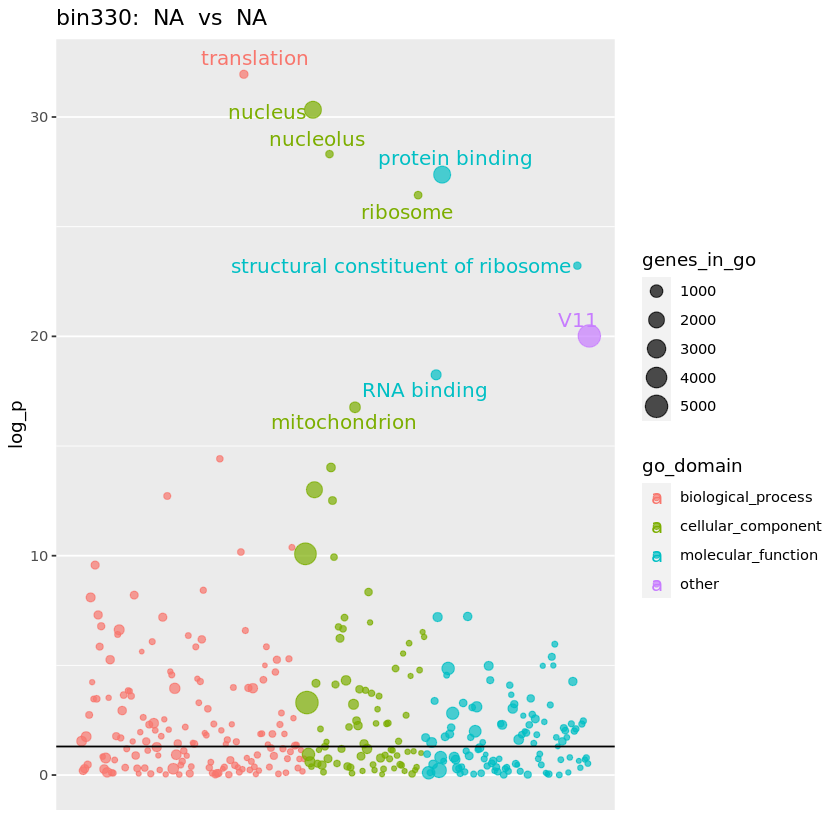

In [10]:
plots

In [ ]:
save(plots, file="bin330_idea_groups_BubblePlots")

In [ ]:
save.image("workspace_bin330.RData",compress=TRUE)